Named Entity Recognition in French biomedical text (Part 2)
===========================================
by Andrés Soto Villaverde
-------------------------------------
[LinkedIn profile](https://www.linkedin.com/in/andres-soto-villaverde-36198a5/)

In the [previous notebook](https://nbviewer.jupyter.org/github/andressotov/Named-Entity-Recognition-in-French-biomedical-text/blob/master/Named%20Entity%20Recognition%20in%20French%20biomedical%20text.ipynb), we introduced the problem of identifying entities in French biomedical texts taken from The QUAERO French Medical Corpus. In this corpus, ten types of clinical entities were annotated: Anatomy, Chemical and Drugs, Devices, Disorders, Geographic Areas, Living Beings, Objects, Phenomena, Physiology, Procedures with the labels: ANAT, CHEM, DEVI, DISO, GEOG, LIVB, OBJC, PHEN, PHYS, PROC. 



Let's show a sample annotation for a MEDLINE text:

**Sample MEDLINE title 1**

    *Chirurgie de la communication interauriculaire du type " sinus venosus " .*
    
**Sample MEDLINE title 1 annotations**

T1           PROC 0 9             Chirurgie


T2           DISO 16 46          communication interauriculaire

This means that the text between characters 0 and 9 is assigned a label PROC (= procedure). The token which corresponds to this text is “Chirurgie”. Second annotation is for the text between characters 16 and 46 (which covers tokens “communication interauriculaire”) and is assigned label DISO (= disorder).

A selection of MEDLINE titles were preprocessed in the previous notebook. The information from the files included in the corpus were transformed into a list of Python dictionaries with the following structure:

The annotation dictionary ('ann_dic') contains a list of tuples with four elements:
* index position of the first character of the segment in the sentences,
* index of the last character of the segment,
* corresponding label of the segment,
* the segment.

The other dictionary field ('txt') contains the whole sentence. The list of dictionaries was saved into a file called 'train_txt_ann3'

Following we will explain the train and test part of the algorithm. In order to train the algorithm, we need first to obtain a vector *y* with the labels for each sentence and a matrix *X* with a set of features for each sentence. 

Let's begin explaining how to extract the labels for each sentence. The function *sentences2labels* converts the list of tuples (a,b,token,label) corresponding to the sentences into list of labels using the function sent2labels for extracting the labels for each sentence (i.e. list of tuples)

In [1]:
def sent2labels(ltup):
    liob = []
    for (token,label) in ltup:
        liob.append(label)
    return liob

def sentences2labels(ls_tok_lab):
    print("extracting labels from sentences...")
    llabs = []
    for ltup in list(ls_tok_lab):
        labs = sent2labels(ltup)
        llabs.append(labs)
    return llabs

By the other hand, we have the function *sentences2features* which converts a list of sentences into a list of lists of features (i.e. each feature correspond to a token and all the features that belong to a sentence are collected into the same list). It returns the list of lists of features.
For each list of tuples (i.e. sentence), it uses the function *word2features* to convert the i-th element (token, label) of the tuple list into a set of features. It returns the set of features.
In this example, the features considered were:
* Is the token lowercase or uppercase?
* Does the token begin with a capital?
* Is the token made up of digits?
* Is the token formed by alphanumeric chars?
* Is the token formed by alphabetic chars?
* the last 3 chars of the token
* the last 2 chars of the token
This set of features is also collected for the previous and following token (if they exist)

In [2]:
def word2features(sent, i):
    token = sent[i][0]     # take word i from the sentence
    features = {
        # setup the features
        'bias': 1.0,
        'word.lower()': token.lower(),  	# Is the token lowercase?
        'word.isupper()': token.isupper(),  # Is the token uppercase?
        'word.istitle()': token.istitle(),  # Does the token begin with a capital?
        'word.isdigit()': token.isdigit(),  # Is the token made up of digits?
        'word.isalnum()': token.isalnum(),  # Is the token formed by alphanumeric chars?
        'word.isalpha()': token.isalpha(),  # Is the token formed by alphabetic chars?
        'word[-3:]': token[-3:],		    # the last 3 chars of the token
        'word[-2:]': token[-2:], 	        # the last 2 chars of the token
    }
    if i > 0:  # if it is not the first word
        token1 = sent[i - 1][0]        # take the previous token
        features.update({               # update the features
            '-1:word.lower()': token1.lower(),      # Is the previous token lowercase?
            '-1:word.isupper()': token1.isupper(),  # Is the previous token uppercase?
            '-1:word.istitle()': token1.istitle(),  # Does it begin with a capital?
            '-1:word.isdigit()': token1.isdigit(),  # Is the previous token made up of digits?
            '-1:word.isalnum()': token1.isalnum(),  # Is the previous token formed by alphanumeric chars?
            '-1:word.isalpha()': token1.isalpha(),  # Is the previous token formed by alphabetic chars?
            '-1:word[-3:]': token1[-3:],            # the last 3 chars of the previous token
            '-1:word[-2:]': token1[-2:],            # the last 2 chars of the previous token
        })
    else:       # if it is the first word
        features['BOS'] = True  # set 'Begin Of Sentence'
    if i < len(sent) - 1:           # if it is not the last word
        token1 = sent[i + 1][0]     # take the next word
        features.update({           # update the features:
            '+1:word.lower()': token1.lower(),      # Is the next token lowercase?
            '+1:word.istitle()': token1.istitle(),  # Does it begin with a capital?
            '+1:word.isupper()': token1.isupper(),  # Is the it uppercase?
            '+1:word.isdigit()': token1.isdigit(),  # Is the next token made up of digits?
            '+1:word.isalnum()': token1.isalnum(),  # Is the next token formed by alphanumeric chars?
            '+1:word.isalpha()': token1.isalpha(),  # Is the next token formed by alphabetic chars?
            '+1:word[-3:]': token1[-3:],            # the last 3 chars of the next token
            '+1:word[-2:]': token1[-2:],            # the last 2 chars of the next token
        })
    else:       # if it is the last word
        features['EOS'] = True  # set 'End Of Sentence'
    return features
    
def sentences2features(ls_tok_lab):
    print("converting sentences to features...")
    lfeat = []
    for ltup in ls_tok_lab:
        lfeat.append([word2features(ltup, i) for i in range(len(ltup))])
    return lfeat

The function *train_test* receives a list of dictionaries with the annotations and text of the sentences as described before. Then it extracts a list of lists of labels that correspond to the list of sentences which is saved into variable **y**

Afterthat it converts the list of sentences into list of lists of features (i.e. each token corresponds to several feature and all the features that belong to a sentence are collected into the same list) which is stored into variable **X**

Then we train the [Conditional Random Field (CRF)](https://en.wikipedia.org/wiki/Conditional_random_field) algorithm with this data using [cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) with 5 groups. It also calculate the classification report as well as the mean score and the 95% confidence interval of the score estimate. The classifier is saved into the file "crf_tagger.pkl"

In [3]:
from sklearn_crfsuite import CRF
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn_crfsuite.metrics import flat_classification_report

def save_pickle(data,file):
    pick_file = open(file+".pkl", "wb")
    pickle.dump(data, pick_file)
    pick_file.close()

def train_test(ls_tok_lab):
    print("Begin training...")
    y = sentences2labels(ls_tok_lab)
    X = sentences2features(ls_tok_lab)

    c1 = 0.005 
    c2 = 0.005 
    all_possible_transitions = True
    max_iterations = 100
    algorithm = 'lbfgs'
    print("Model CRF algorithm=",algorithm,"c1=", c1, "c2=", c2,
          "max_iterations=",max_iterations,
          "all_possible_transitions=",all_possible_transitions)
    crf = CRF(algorithm=algorithm,c1=c1,c2= c2,
              max_iterations=max_iterations,
              all_possible_transitions=all_possible_transitions)

    print("Use cross_val_predict cv=5")
    pred = cross_val_predict(estimator=crf, X=X, y=y, cv=5)
    report = flat_classification_report(y_pred=pred, y_true=y)
    print("classification_report")
    print(report)
    print("Use cross_val_score with cv=5")
    scores = cross_val_score(crf, X, y, cv=5)
    # The mean score and the 95% confidence interval of the
    # score estimate are hence given by:
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    crf.fit(X=X, y=y)    
    save_pickle(crf, "crf_tagger")
    return report

We can now start the whole process.

In [4]:
import os
import pickle

def load_pickle(file):
    pick_file = open(file+".pkl", "rb")
    data = pickle.load(pick_file)
    pick_file.close()
    return data

def step1(set):
    ls_tok_lab = load_pickle(set + '_txt_ann3')
    report = train_test(ls_tok_lab)
    return report

In [5]:
set = 'train'
# First step: train and test the model
report = step1(set)

Begin training...
extracting labels from sentences...
converting sentences to features...
Model CRF algorithm= lbfgs c1= 0.005 c2= 0.005 max_iterations= 100 all_possible_transitions= True
Use cross_val_predict cv=5
classification_report
              precision    recall  f1-score   support

        ANAT       0.48      0.32      0.38       377
        CHEM       0.53      0.39      0.45       421
        DEVI       0.29      0.04      0.07        52
        DISO       0.58      0.59      0.58      1335
        GEOG       0.79      0.41      0.54        37
        LIVB       0.63      0.40      0.49       347
        NONE       0.84      0.86      0.85      6963
        OBJC       0.29      0.07      0.11        29
        PHEN       0.07      0.02      0.03        56
        PHYS       0.33      0.19      0.24       172
        PROC       0.34      0.47      0.40       755

   micro avg       0.72      0.72      0.72     10544
   macro avg       0.47      0.34      0.38     10544
weigh

Now let's analyze in some detail the obtained results. The classification report offers a text summary of the precision, recall, F1 score for each category. The reported averages include: 
* macro average: averaging the unweighted mean per label, 
* weighted average: averaging the support-weighted mean per label, and
* micro average: averaging the total true positives, false negatives and false positives. It is only shown for multi-label or multi-class with a subset of classes because it is accuracy otherwise.

Both micro and weighted average shows acceptable results (over 70%), while macro average is considerably lower. 
Analysing the results by category, we can see that the best results (over 80%) were obtained with category NONE, which corresponds to words that are not in any of the others category. We can see also that there were 6963 NONE words included into the sentences processed, which is a much higher value than all the others. 
We will show these results graphically.

In [6]:
import numpy as np

# Create a function called "chunks" with two arguments, l and n:
def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]

# Transform the report in string format into a list of chunks
# one chunk for each report row 
r1 = report.replace('avg','')
r1 = r1.split()
r1.insert(0,'label')
llists = list(chunks(r1, 5))
llists

[['label', 'precision', 'recall', 'f1-score', 'support'],
 ['ANAT', '0.48', '0.32', '0.38', '377'],
 ['CHEM', '0.53', '0.39', '0.45', '421'],
 ['DEVI', '0.29', '0.04', '0.07', '52'],
 ['DISO', '0.58', '0.59', '0.58', '1335'],
 ['GEOG', '0.79', '0.41', '0.54', '37'],
 ['LIVB', '0.63', '0.40', '0.49', '347'],
 ['NONE', '0.84', '0.86', '0.85', '6963'],
 ['OBJC', '0.29', '0.07', '0.11', '29'],
 ['PHEN', '0.07', '0.02', '0.03', '56'],
 ['PHYS', '0.33', '0.19', '0.24', '172'],
 ['PROC', '0.34', '0.47', '0.40', '755'],
 ['micro', '0.72', '0.72', '0.72', '10544'],
 ['macro', '0.47', '0.34', '0.38', '10544'],
 ['weighted', '0.72', '0.72', '0.72', '10544']]

In [7]:
col_labels = ['precision', 'recall', 'f1', 'support']
# Extract the report column 0 corresponding to the labels (without the heading)
labels = [item[0] for item in llists][1:]
l = list(reversed(labels))[3:]

In [8]:
# Extract the report column 1 corresponding to precision results
precision = [item[1] for item in llists][1:]
precision = [float(p) for p in precision] # string --> float
p = list(reversed(precision))[3:]

In [9]:
# Extract the report column 2 corresponding to recall results
recall = [item[2] for item in llists][1:]
recall = [float(p) for p in recall] # string --> float
r = list(reversed(recall))[3:]

In [10]:
# Extract the report column 3 corresponding to F1-score results
f1 = [item[3] for item in llists][1:]
f1 = [float(p) for p in f1] # string --> float
f = list(reversed(f1))[3:]

In [11]:
# Extract the report column 4 corresponding to support results
support = [item[4] for item in llists][1:]
support = [int(p) for p in support] # string --> integer
s = list(reversed(support))[3:]

In [12]:
import pandas as pd

df = pd.DataFrame(np.corrcoef([p,r,f,s]),
                  columns=['precision','recall','F1-score','Support'],
                  index=['precision','recall','F1-score','Support'])
df

,precision,recall,F1-score,Support
precision,1.000000,0.825190,0.918620,0.562933
recall,0.825190,1.000000,0.977194,0.774146
F1-score,0.918620,0.977194,1.000000,0.715011
Support,0.562933,0.774146,0.715011,1.000000


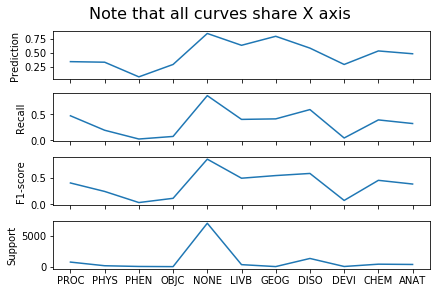

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt

fig, axarr = plt.subplots(4, constrained_layout=True, sharex=True)
fig.suptitle('Note that all curves share X axis', fontsize=16)

axarr[0].plot(l, p)
axarr[1].plot(l, r)
axarr[2].plot(l, f)
axarr[3].plot(l, s)
axarr[0].set_ylabel('Prediction')
axarr[1].set_ylabel('Recall')
axarr[2].set_ylabel('F1-score')
axarr[3].set_ylabel('Support')
plt.show()

We can observe that:
* all the curves are sharing the X-axis
* only the curve that appears at the bottom, i.e. the *support* one, has integer values in the range [0, 7000]. All the other graphic vary between 0 and 1.
* the value at label *NONE* at the *support* curve is very much higher than the other values.
* all curves get the higher value at label *NONE* as we noticed before
* the second higher value at the *precision* curve is obtained at label *GEOG*, although the *recall* value is not so good
* the value at label *DISO* is the second higher for the *support* curve as the values for *precision*, *recall* and *F1* for label *DISO* are also high 

We can assume that there is a certain correlation between the values for the *support* curve and the values for the other curves. Let's calculate the [Pearson correlation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.corrcoef.html) between those values.

In [14]:
import pandas as pd

df = pd.DataFrame(np.corrcoef([p,r,f,s]),
                  columns=['precision','recall','F1-score','Support'],
                  index=['precision','recall','F1-score','Support'])
df

,precision,recall,F1-score,Support
precision,1.000000,0.825190,0.918620,0.562933
recall,0.825190,1.000000,0.977194,0.774146
F1-score,0.918620,0.977194,1.000000,0.715011
Support,0.562933,0.774146,0.715011,1.000000


Observing the right hand column (i.e. *support*), we can see that there does not exist a total correlation, but certainly there exist a positive correlation between the *support* values and the *precision*, *recall* and *F1*, which is higher for *recall* values

I hope that you have found this blog useful and interesting. In future updates, I will continue trying to improve the scores obtained here. Thank you for reading me!